In [32]:
# 📚 Multi-label Dog Breed Classifier with ResNet50
# By: ChatGPT + 이상현님

In [4]:
# ✅ 1. Import Libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [6]:
# ✅ 2. Multi-label Dataset Class
class MultiLabelDogDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.class_names = list(self.annotations.columns[1:])
        self.num_classes = len(self.class_names)
    def __len__(self):
        return len(self.annotations)
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[idx, 0])
        image = Image.open(img_path).convert("RGB")
        labels = torch.tensor(self.annotations.iloc[idx, 1:].values.astype(np.float32))
        if self.transform:
            image = self.transform(image)
        return image, labels

In [7]:
# ✅ 3. Settings
data_dir = "./dog_training_set"
csv_path = "./labels.csv"
batch_size = 32
num_epochs = 10

In [8]:
# ✅ 4. Image Transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [9]:
# ✅ 5. Dataset & DataLoader
train_dataset = MultiLabelDogDataset(csv_file=csv_path, root_dir=data_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
class_names = train_dataset.class_names
num_classes = train_dataset.num_classes

In [11]:
# ✅ 6. Model Definition
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [13]:
# ✅ 7. Loss & Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [41]:
# ✅ 8. Training Loop
print("🚀 Training Started...")
for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if (i + 1) % 1 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss:.4f}")
            running_loss = 0.0

🚀 Training Started...
Epoch [1/10], Step [1/21], Loss: 0.6717
Epoch [1/10], Step [2/21], Loss: 0.3257
Epoch [1/10], Step [3/21], Loss: 0.1953
Epoch [1/10], Step [4/21], Loss: 0.1829
Epoch [1/10], Step [5/21], Loss: 0.1246
Epoch [1/10], Step [6/21], Loss: 0.2358
Epoch [1/10], Step [7/21], Loss: 0.2010
Epoch [1/10], Step [8/21], Loss: 0.1029
Epoch [1/10], Step [9/21], Loss: 0.1829
Epoch [1/10], Step [10/21], Loss: 0.0766
Epoch [1/10], Step [11/21], Loss: 0.1109
Epoch [1/10], Step [12/21], Loss: 0.1533
Epoch [1/10], Step [13/21], Loss: 0.1451
Epoch [1/10], Step [14/21], Loss: 0.3126
Epoch [1/10], Step [15/21], Loss: 0.1132
Epoch [1/10], Step [16/21], Loss: 0.1766
Epoch [1/10], Step [17/21], Loss: 0.1343
Epoch [1/10], Step [18/21], Loss: 0.1500
Epoch [1/10], Step [19/21], Loss: 0.1870
Epoch [1/10], Step [20/21], Loss: 0.1199
Epoch [1/10], Step [21/21], Loss: 0.1278
Epoch [2/10], Step [1/21], Loss: 0.1143
Epoch [2/10], Step [2/21], Loss: 0.1511
Epoch [2/10], Step [3/21], Loss: 0.0693
Epoch 

In [14]:
# ✅ 9. Save Model
model_path = "./resnet50_multilabel.pth"
torch.save(model.state_dict(), model_path)
print(f"✅ Model saved at: {model_path}")

✅ Model saved at: ./resnet50_multilabel.pth


In [15]:
# ✅ 10. Prediction Function
def load_model(model_path, num_classes):
    model = models.resnet50(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.load_state_dict(torch.load(model_path, map_location=torch.device("cpu")))
    model.eval()
    return model

In [16]:
def predict_sample(image_path, model, class_names, threshold=0.3):
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    image_tensor = transform(image).unsqueeze(0)
    with torch.no_grad():
        output = model(image_tensor)
        probs = torch.sigmoid(output[0])
    predicted_indices = (probs > threshold).nonzero(as_tuple=True)[0]
    predicted_labels = [class_names[i] for i in predicted_indices]
    confidences = [probs[i].item() for i in predicted_indices]
    plt.imshow(image)
    plt.title("Predicted: " + ', '.join([f"{l} ({c:.2f})" for l, c in zip(predicted_labels, confidences)]))
    plt.axis('off')
    plt.show()
    print("🔍 Predicted Breeds:")
    for label, conf in zip(predicted_labels, confidences):
        print(f"→ {label}: {conf:.2f}")

C:\Users\tkdgu\anaconda3\envs\Pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\tkdgu\AppData\Local\Temp\ipykernel_10756\105121931.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `tor

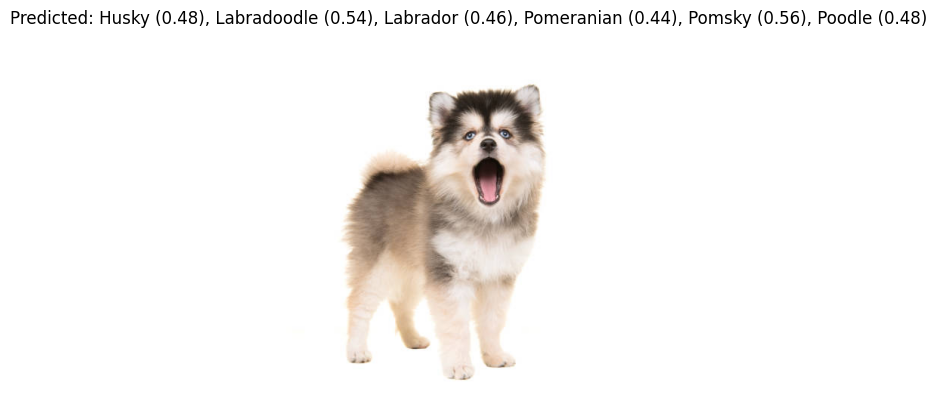

🔍 Predicted Breeds:
→ Husky: 0.48
→ Labradoodle: 0.54
→ Labrador: 0.46
→ Pomeranian: 0.44
→ Pomsky: 0.56
→ Poodle: 0.48


In [17]:
# ✅ 11. Run prediction (예시)
sample_image = "./111.jpg"
model_loaded = load_model(model_path, num_classes)
predict_sample(sample_image, model_loaded, class_names)